# Análise dos Resultados Obtidos durante as Iterações do Processo de Active Learning
Nesse notebok estão algumas métricas de avaliação do processo iterativo.

- Evolução da quantidade durante as iterações
- Evolução das métricas de algumas métricas, como: Acurácia, F1-Score, KappaScore e IoU

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

import os
import subprocess
from collections.abc import Iterable
from glob import glob
from os.path import dirname, join
from statistics import mode

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim
from IPython.display import HTML, display
from joblib import Parallel, delayed
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
from millify import millify
from PIL import Image
from pyproj import Transformer
from skimage.color import label2rgb
# load label
from skimage.measure import find_contours, label
from tqdm import tqdm

from pred2raster import pred2raster
from sample_selection import get_components_stats
from src.io_operations import (fix_relative_paths, get_image_metadata,
                               get_image_pixel_scale, load_args, read_tiff,
                               read_yaml)
from utils import *

import warnings
warnings.filterwarnings('ignore')
import textwrap



In [3]:

def wrap_text(text, width, break_long_words=False):
    return textwrap.fill(text, width=width, break_long_words=break_long_words)

def format_y_ticks(value, _):
    return millify(value, precision=1)


def normalize_img(image):
    
    image = (image - image.min(axis=(0,1))) / (np.quantile(image, 0.99, axis=(0,1)) - image.min())
    
    return image

In [4]:
# Style plots
sns.set_theme(style="whitegrid", font="Times New Roman")

# set figsize
plt.rcParams["figure.figsize"] = (8, 5)

# increase DPI
plt.rcParams["figure.dpi"] = 120

# font family
plt.rcParams['font.family'] = 'times new roman'

DEFAULT_FONT_SIZE = 8
plt.rc('xtick', labelsize=DEFAULT_FONT_SIZE)  
plt.rc('ytick', labelsize=DEFAULT_FONT_SIZE)

# Dict to store colors
dict_colors = {}

# Parallel jobs to load m etrics
N_JOBS = 10

### Defina a pasta com a saída do processo de Active Learning

In [5]:
# Repo with training data
INPUT_PATH = "../amazon_input_data"

# repo with model outputs
VERSION_FOLDER = "/home/luiz.luz/multi-task-fcn/13_amazon_data"
DATA_PATH = join(dirname(os.getcwd()), VERSION_FOLDER)

# load args from the version
args = load_args(join(DATA_PATH, "args.yaml"))

In [6]:
def get_iter_stats(iter_folder, labels_file="all_labels_set.tif"):
    
    if "all_labels" in labels_file:
        ITER_STATS_PATH = join(DATA_PATH, iter_folder, "all_labels_stats.parquet")
        
    if "selected_labels" in labels_file:
        ITER_STATS_PATH = join(DATA_PATH, iter_folder, "selected_labels_stats.parquet")
    
    if os.path.exists(ITER_STATS_PATH):
        return pd.read_parquet(ITER_STATS_PATH)
    
    num_iter = int(iter_folder.split("_")[1])
    
    if num_iter != 0:
        label_path = join(DATA_PATH, iter_folder, "new_labels", labels_file)
        
    else:
        label_path = args.train_segmentation_path

    label_img = read_tiff(label_path)

    components = label(label_image = label_img)

    components_stats = get_components_stats(components, label_img)
    components_stats.reset_index(inplace=True)


    components_stats["iter"] = f"iter_{num_iter:03d}"

    components_stats["iter_num"] = num_iter
    
    # save parquet with stats at
    components_stats.to_parquet(ITER_STATS_PATH)
    
    return components_stats

### Data loading

In [7]:
id_tree = pd.read_csv(join(INPUT_PATH,"id_trees.csv"), index_col="label_num")["tree_name"].sort_values()

In [8]:
# load data from all iterations
iter_folders = os.listdir(DATA_PATH)

iter_folders = [folder for folder in iter_folders if folder.startswith("iter_")]

iter_folders.sort()

iter_folders.pop();

In [9]:
OUTPUT_PATH_ALL_LABELS_STATS = join(DATA_PATH, "all_labels_stats.parquet")

# carregando dados sobre cada iteracao
all_iter_stats = Parallel(n_jobs=N_JOBS)(
    delayed(get_iter_stats)(iter_folder, "all_labels_set.tif")
    for iter_folder in iter_folders
)

# all_iter_stats corresponde dados gerados para o banco de imagens
all_labels_stats = pd.concat(all_iter_stats)

all_labels_stats["tree_name"] = all_labels_stats["tree_type"].map(id_tree);


In [10]:
OUTPUT_PATH_SELECTED_LABELS_STATS = join(DATA_PATH, "selected_labels_stats.parquet")

selected_iter_stats = Parallel(n_jobs=N_JOBS)(
    delayed(get_iter_stats)(iter_folder, "selected_labels_set.tif")
    for iter_folder in iter_folders
)

# all_iter_stats corresponde dados gerados para o cojunto de treinamento
selected_labels_stats = pd.concat(selected_iter_stats)

selected_labels_stats["tree_name"] = selected_labels_stats["tree_type"].map(id_tree)

In [11]:
metrics_evo = []

for num_iter, iter in enumerate(iter_folders[1:]):
    
    accu = read_yaml(os.path.join(DATA_PATH, iter, "test_metrics.yaml"))
    accu["iter_num"] = num_iter + 1
    
    metrics_evo.append(accu)
    
metrics_evo = pd.DataFrame(metrics_evo)
metrics_evo.columns = metrics_evo.columns.str.replace("test/", "")

In [12]:
ORTHOIMAGE = read_tiff(args.ortho_image)
ORTHOIMAGE = np.moveaxis(ORTHOIMAGE, 0, 2)

if ORTHOIMAGE.shape[-1] == 25:
    ORTHOIMAGE = ORTHOIMAGE[...,[5,3,2]].copy()

if ORTHOIMAGE.max() > 255:
    ORTHOIMAGE[:] = ORTHOIMAGE/np.quantile(ORTHOIMAGE, 0.99, axis = (0,1))

In [13]:
TRAIN_GT = read_tiff(args.train_segmentation_path)
COMP_TRAIN_GT = label(TRAIN_GT)

In [14]:
TEST_GT = read_tiff(args.test_segmentation_path)
# Data from TRAIN in TEST
TEST_GT = np.where(TRAIN_GT>0, 0, TEST_GT)
COMP_TEST_GT = label(TEST_GT)

In [15]:
PRED = read_tiff(join(DATA_PATH,iter_folders[-1],"new_labels", "all_labels_set.tif"))
COMP_PRED = label(PRED)

In [16]:
orthoimage_metadata = get_image_metadata(args.ortho_image)
# convert to default coordinate system
transfomer = Transformer.from_crs(orthoimage_metadata["crs"], "epsg:4326")
x_scale, y_scale = get_image_pixel_scale(args.ortho_image)

## Setting Color Palette 

In [17]:
if all_labels_stats["tree_type"].nunique() == 17:
    dict_colors["tree_name"] = {
        key: color for key, color in zip(id_tree, sns.color_palette("tab20"))
    }

    dict_colors["tree_type"] = {
        key: color for key, color in zip(range(0, 18), sns.color_palette("tab20"))
    }

In [18]:

if all_labels_stats["tree_type"].nunique() == 14:
    
    DEFAULT_COLORS = ('silver', 'blue', 'yellow', 'magenta', 'green', 
                        'indigo', 'darkorange', 'cyan', 'pink', 'yellowgreen', 
                        'red', 'darkgreen', 'gold', 'teal')

    dict_colors["tree_name"] = {
        key: color for key, color in zip(id_tree, DEFAULT_COLORS)
    }

    dict_colors["tree_type"] = {
        key: color for key, color in zip(range(0, 18), DEFAULT_COLORS)
    }

## Process Data

In [19]:
# convertendo métricas de área de pxl^2 para metros^2
all_labels_stats["area_m2"] = all_labels_stats["area"] * x_scale * y_scale
all_labels_stats["area_km2"] = (all_labels_stats["area_m2"])/(10**6)

selected_labels_stats["area_m2"] = selected_labels_stats["area"] * x_scale * y_scale
selected_labels_stats["area_km2"] = (selected_labels_stats["area_m2"])/(10**6)

# Big Numbers Área de Estudo

In [20]:
area_pxl = (ORTHOIMAGE.shape[0]*ORTHOIMAGE.shape[1])

In [21]:
print("Área:")
print(f"{((ORTHOIMAGE.shape[0]*ORTHOIMAGE.shape[1])*x_scale * y_scale):,.2f} (m)²")
print("Ou")
print(f"{((ORTHOIMAGE.shape[0]*ORTHOIMAGE.shape[1])*x_scale * y_scale/1_000_000):,.2f} (km)²")
print("Ou")
print(f"{((ORTHOIMAGE.shape[0]*ORTHOIMAGE.shape[1])*x_scale * y_scale/10_000):,.2f} Hectares")

Área:
1,910,251.68 (m)²
Ou
1.91 (km)²
Ou
191.03 Hectares


## Evolução da Quantidade de Instâncias e Área Segmentada
Para essa análise, serão consideradas instâncias presentes no inventário de amostras. Nesse inventário estão as amostras em que o modelo teve alta confiança na predição e que passaram pelo filtro de seleção com base nas heurísticas.

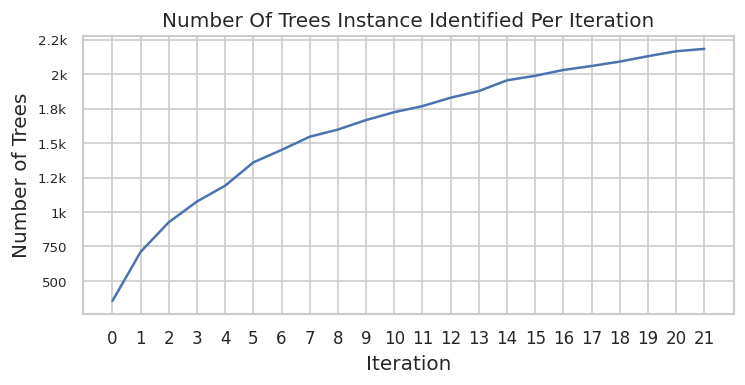

In [22]:
# change size fig
fig = plt.gcf()
fig.set_size_inches(7, 3)

count_tree_by_iter = all_labels_stats.groupby(["iter_num"], as_index=False, sort=True)["label"].nunique()
count_tree_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

ax = sns.lineplot(
    data=count_tree_by_iter,
    x="iter_num",
    y="n_trees",
)

ax.set_title("Number of Trees Instance Identified per Iteration".title())

ax.set_ylabel("Number of Trees")
ax.set_xlabel("Iteration")

ax.set_xticks(all_labels_stats['iter_num'].unique())
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":10})

format_millify_axis(ax, "y", precision= 1)
plt.show()

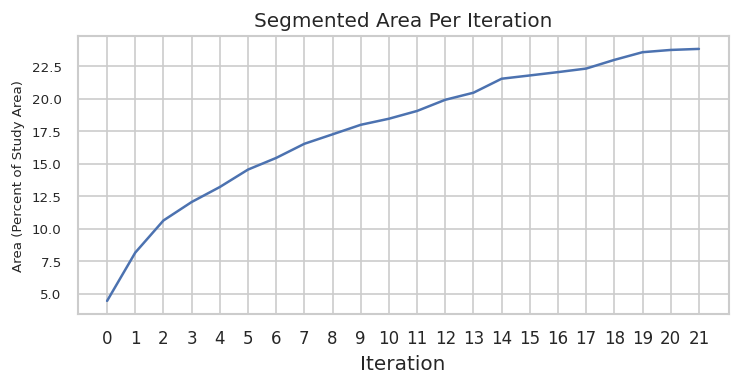

In [23]:
# Segmentation area per iteration
# change size fig
fig = plt.gcf()
fig.set_size_inches(7, 3)



area_tree_by_iter = all_labels_stats.groupby(["iter_num"], as_index=False, sort=True)["area"].sum()
area_tree_by_iter.rename(columns={"label": "n_trees"}, inplace=True)
area_tree_by_iter["area"] = area_tree_by_iter["area"] / area_pxl * 100

ax = sns.lineplot(
    data=area_tree_by_iter,
    x="iter_num",
    y="area",
)

ax.set_title("Segmented Area per Iteration".title())
ax.set_ylabel("Area (Percent of Study Area)", fontsize=8)
ax.set_xlabel("Iteration")


ax.set_xticks(all_labels_stats['iter_num'].unique())
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":10})

# format_millify_axis(ax, "y", precision= 2)
# format with func formatter
# ax.yaxis.

plt.show()

In [24]:
count_tree_type_by_iter = all_labels_stats.groupby(["iter_num", "tree_name"], as_index=False, sort=True)["label"].nunique()
count_tree_type_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

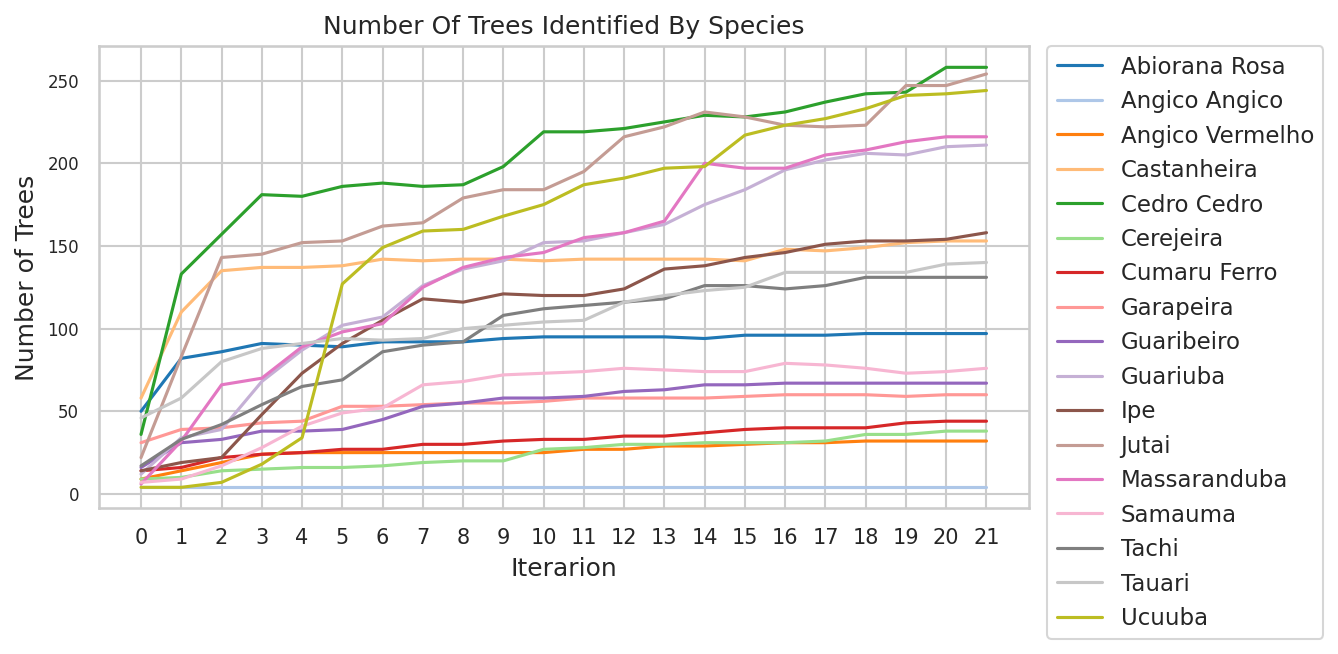

Evolução por espécies


In [25]:
# change size fig
fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.set_dpi(150)

ax = sns.lineplot(
    data=count_tree_type_by_iter,
    x="iter_num",
    y="n_trees",
    hue="tree_name",
    errorbar = None,
    palette=dict_colors["tree_name"],
)

ax.set_title("Number of Trees Identified By Species".title())

ax.set_ylabel("Number of Trees")
ax.set_xlabel("Iterarion")

ax.set_xticks(all_labels_stats['iter_num'].unique())
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":10})

format_millify_axis(ax, "y", precision= 2)

set_legend_outside_plot(ax)

plt.show()

print("Evolução por espécies")
display(
    count_tree_type_by_iter.pivot(columns="iter_num", index="tree_name", values="n_trees").style.background_gradient(axis = 1)
)

In [26]:
display(
    count_tree_type_by_iter.pivot(columns="iter_num", index="tree_name", values="n_trees").diff(axis=1).style.background_gradient(axis = 1)
)

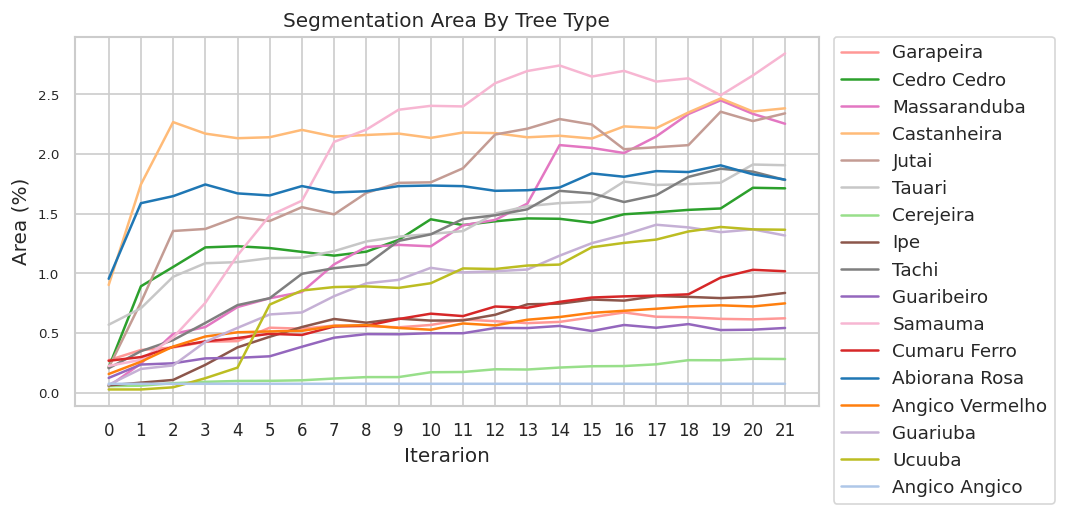

In [27]:
fig = plt.gcf()
fig.set_size_inches(8, 4)

all_labels_stats["area_pct"] = (all_labels_stats['area']/area_pxl)*100

ax = sns.lineplot(
    data=all_labels_stats,
    x="iter_num",
    y="area_pct",
    hue="tree_name",
    estimator="sum",
    errorbar=None,
    palette=dict_colors["tree_name"],
)

ax.set_title("Segmentation Area By Tree Type")

ax.set_ylabel("Area (%)")
ax.set_xlabel("Iterarion")

ax.set_xticks(all_labels_stats['iter_num'].unique())
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"fontsize":10})

# format_millify_axis(ax, "y", precision= 2)

set_legend_outside_plot(ax)

plt.show()

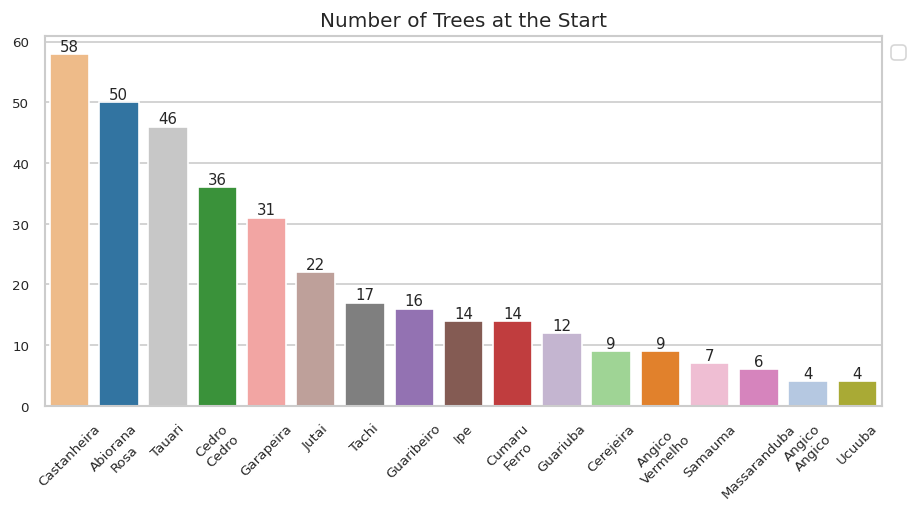

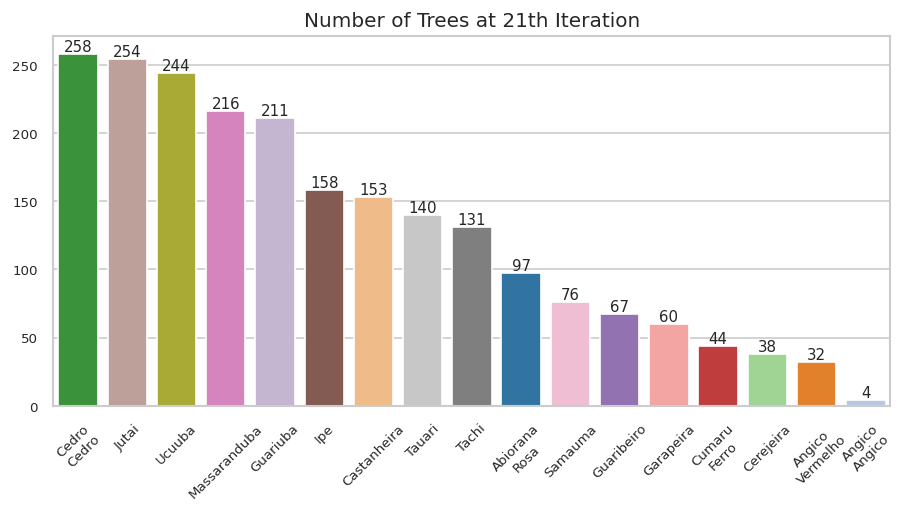

In [28]:
fig = plt.gcf()
fig.set_size_inches(9, 4)

ax = sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == 0],
    x="tree_name",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=all_labels_stats[all_labels_stats["iter_num"] == 0]
            .groupby("tree_name")["label"]
            .nunique()
            .sort_values(ascending=False)
            .index,
    palette=dict_colors["tree_name"],
    hue = "tree_name"
)

ax.set_title(f"Number of Trees at the Start")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{millify(y, 2)}"))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9) for label in ax.get_xticklabels()])
autolabel(ax, "{:,.0f}")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()


### LAST ITER  ###
fig = plt.gcf()
fig.set_size_inches(9, 4)


ax = sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()],
    x="tree_name",
    y="label",
    estimator=lambda group: group.nunique(),
    errorbar=None,
    order=all_labels_stats[all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()].groupby("tree_name")["label"]
        .nunique()
        .sort_values(ascending=False)
        .index,
    palette=dict_colors["tree_name"],
    hue="tree_name"
)


ax.set_title(f"Number of Trees at {all_labels_stats['iter_num'].max()}th Iteration")

autolabel(ax, "{:,.0f}")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{millify(y, 2)}"))

ax.tick_params(axis='x', rotation=45)
ax.set_xticklabels([wrap_text(label.get_text(), 9, False) for label in ax.get_xticklabels()])

ax.set_ylabel("")
ax.set_xlabel("")



plt.show()

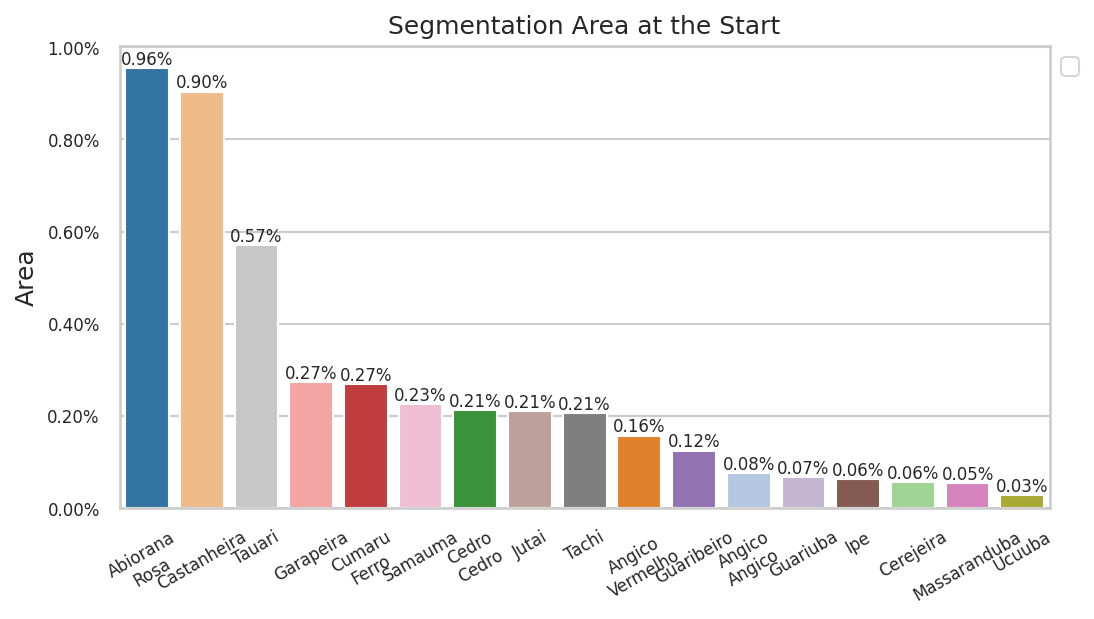

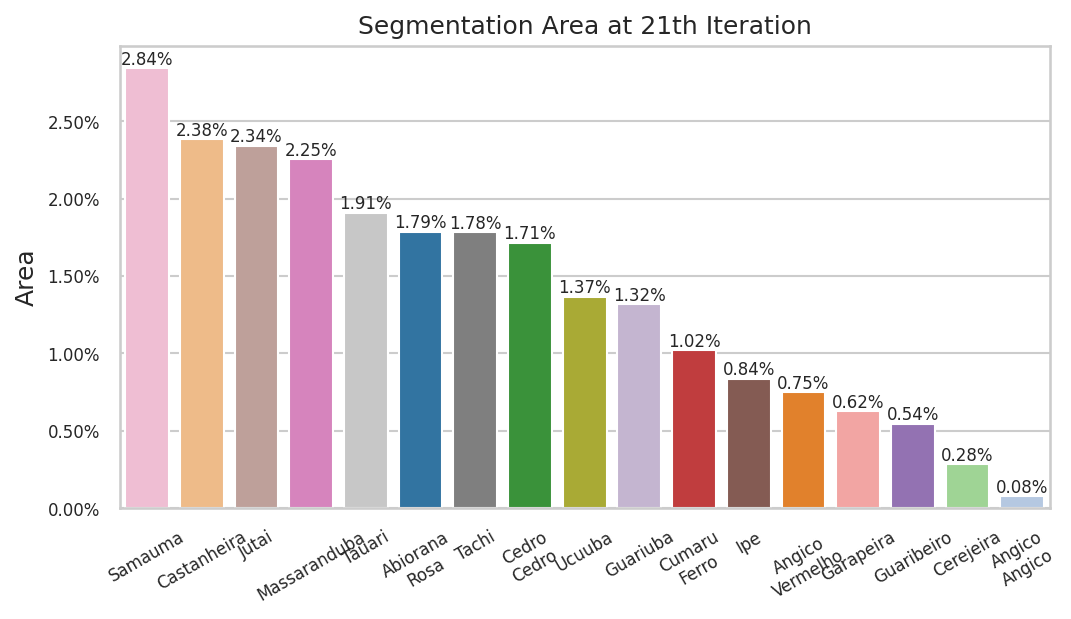

In [29]:
fig = plt.gcf()
fig.set_size_inches(8,4)
# set dpi
fig.set_dpi(150)

ax = sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == 0],
    x="tree_name",
    y="area",
    estimator=lambda group: (group.sum()/area_pxl),
    errorbar=None,
    order=all_labels_stats[all_labels_stats["iter_num"] == 0]
            .groupby("tree_name")["area_m2"]
            .sum()
            .sort_values(ascending=False)
            .index,
    palette=dict_colors["tree_name"],
    hue = "tree_name"
)

ax.set_title(f"Segmentation Area at the Start")

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2%}"))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

ax.tick_params(axis='x', rotation=30)
ax.set_xticklabels([wrap_text(label.get_text(), 10) for label in ax.get_xticklabels()])
autolabel(ax, "{:.2%}", 8)

ax.set_ylabel("Area")
ax.set_xlabel("")

plt.show()


### LAST ITER  ###
fig = plt.gcf()
fig.set_size_inches(8,4)

fig.set_dpi(150)

ax = sns.barplot(
    data=all_labels_stats[all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()],
    x="tree_name",
    y="area",
    estimator=lambda group: (group.sum()/area_pxl),
    errorbar=None,
    order=all_labels_stats[all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()].groupby("tree_name")["area_m2"]
        .sum()
        .sort_values(ascending=False)
        .index,
    palette=dict_colors["tree_name"],
    hue="tree_name"
)


ax.set_title(f"Segmentation Area at {all_labels_stats['iter_num'].max()}th Iteration")

autolabel(ax, "{:.2%}", 8)
# change
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2%}"))

ax.tick_params(axis='x', rotation=30)
ax.set_ylabel("Area")
ax.set_xlabel("")

ax.set_xticklabels([wrap_text(label.get_text(), 10) for label in ax.get_xticklabels()])

plt.show()

## Evolução Temporal do Conjunto de Treino

O conjunto de treino corresponde apenas as labels usadas para treinar o modelo, ou seja, esses dados são apenas um subconjunto do inventário com amostras de alta confiança.

Essas análises tem como objetivo identificar o balanceamento das amostras usadas no treino

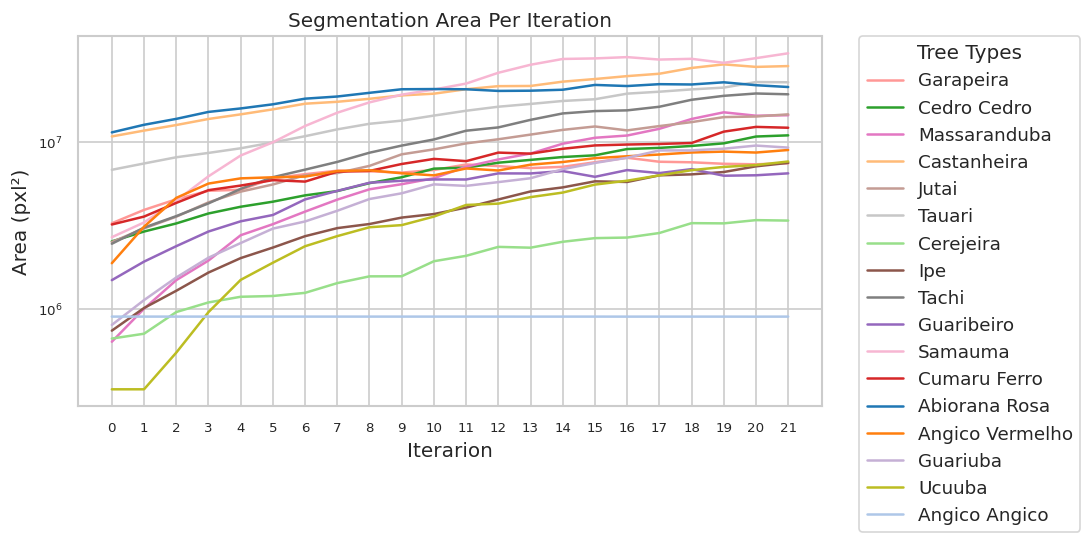

In [30]:
plt.figure(figsize=(8,4))

ax = sns.lineplot(
    data=selected_labels_stats,
    x="iter_num",
    y="area",
    hue="tree_name",
    estimator="sum",
    errorbar=None,
    palette=dict_colors["tree_name"],
)

ax.set_title("Segmentation Area per iteration".title())

# set y log scale
ax.set_yscale("log")

ax.set_ylabel("Area (pxl²)")
ax.set_xlabel("Iterarion")

# set outside box legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title="Tree Types")
ax.set_xticks(selected_labels_stats['iter_num'].unique())

plt.show()

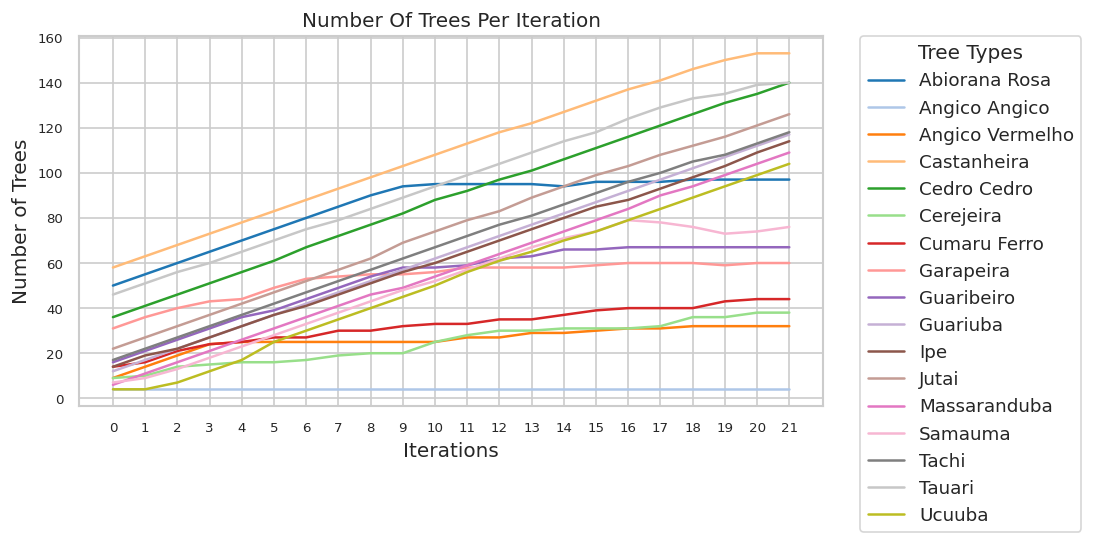

In [31]:
count_by_iter = selected_labels_stats.groupby(
    ["tree_name", "iter_num"], as_index=False, sort=True
)["label"].nunique()
count_by_iter.rename(columns={"label": "n_trees"}, inplace=True)

# change size fig
fig = plt.gcf()
fig.set_size_inches(8, 4)

ax = sns.lineplot(
    data=count_by_iter,
    x="iter_num",
    y="n_trees",
    hue="tree_name",
    errorbar=None,
    palette=dict_colors["tree_name"],
)
# set outside box legend
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, title="Tree Types")

ax.set_title("Number of trees per iteration".title())
ax.set_xticks(selected_labels_stats['iter_num'].unique())

ax.set_ylabel("Number of Trees")
ax.set_xlabel("Iterations")

plt.show()

## Evolução da Distribuição da Área Durante as Iterações

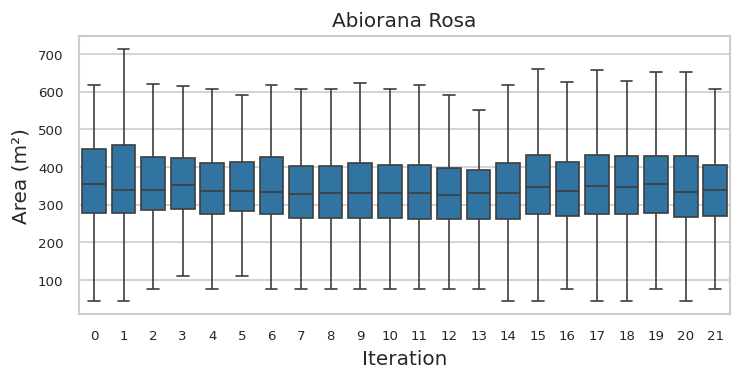

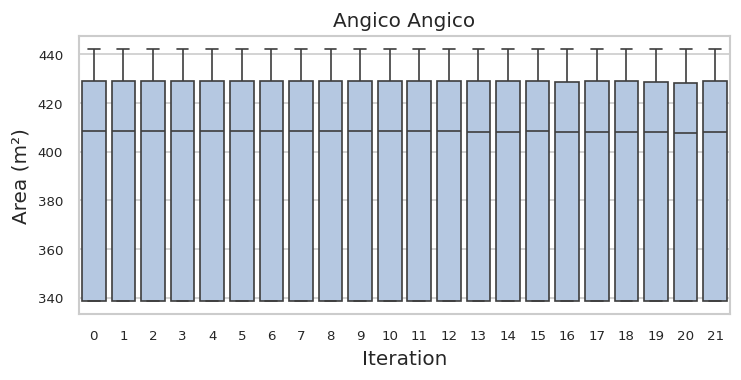

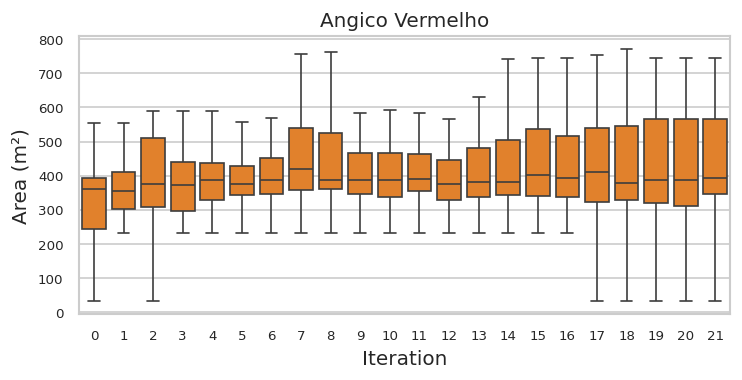

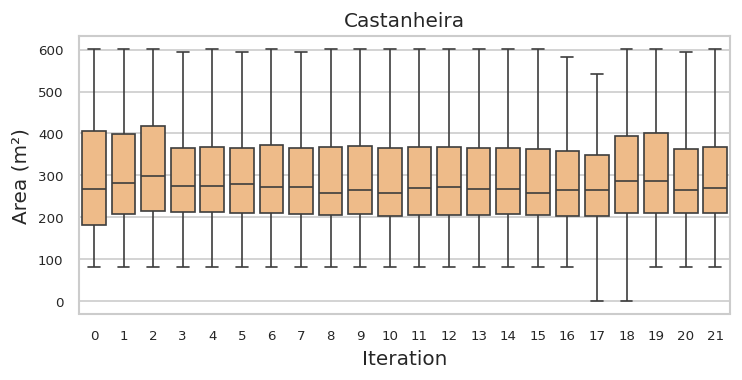

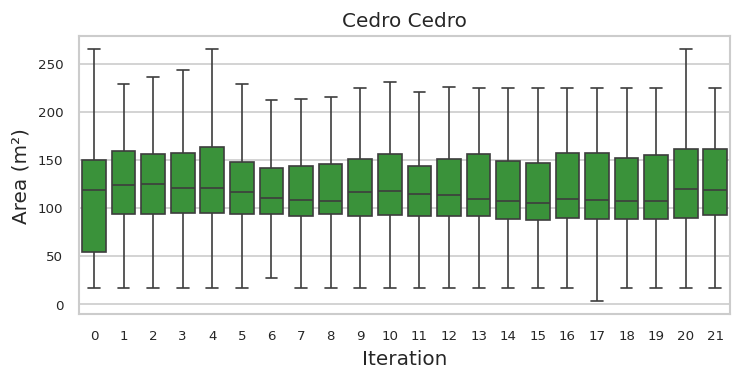

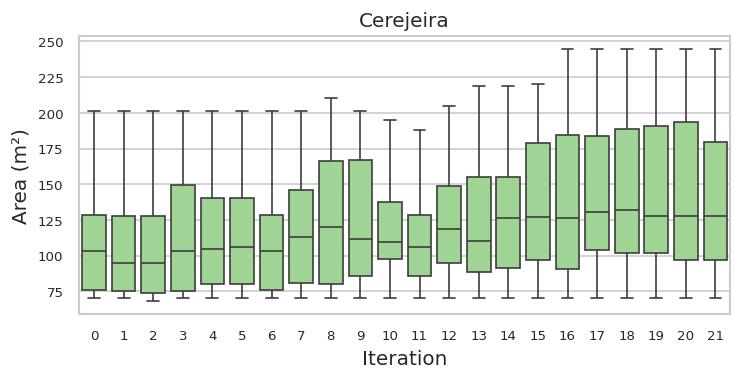

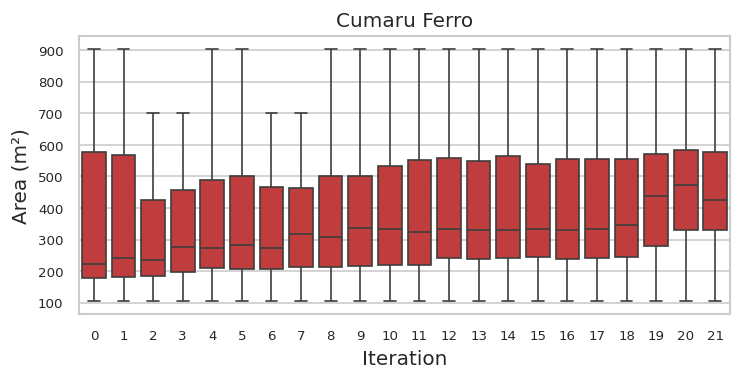

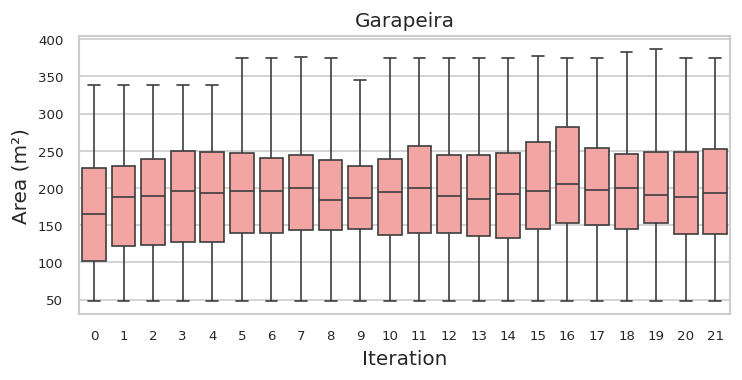

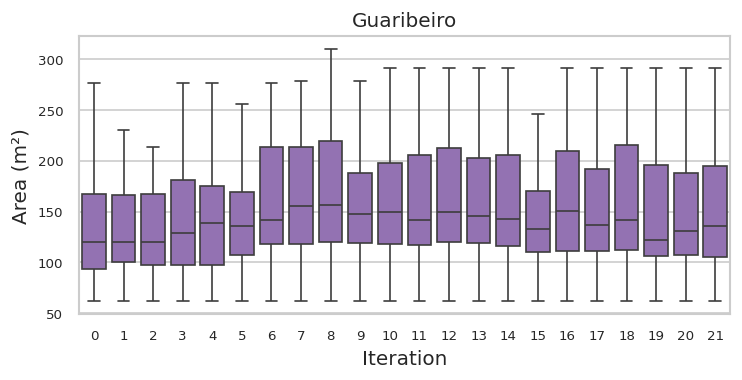

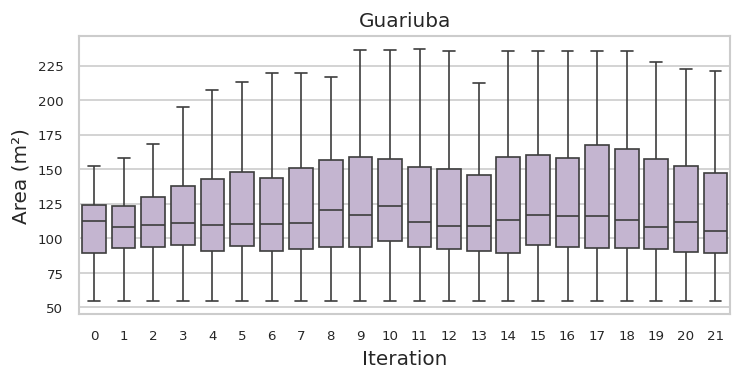

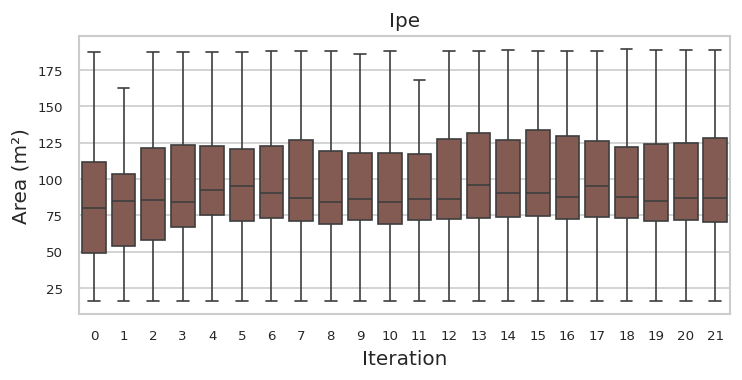

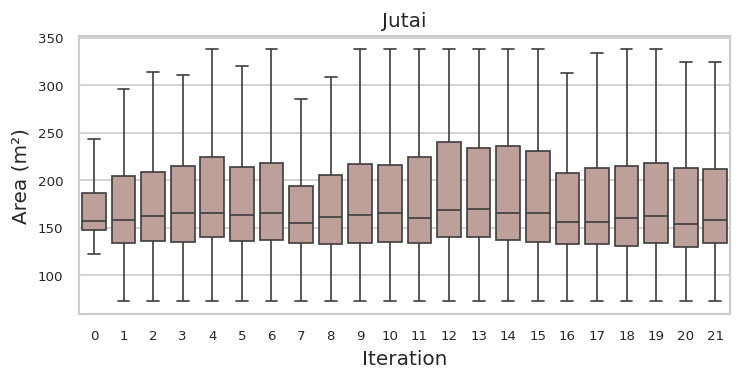

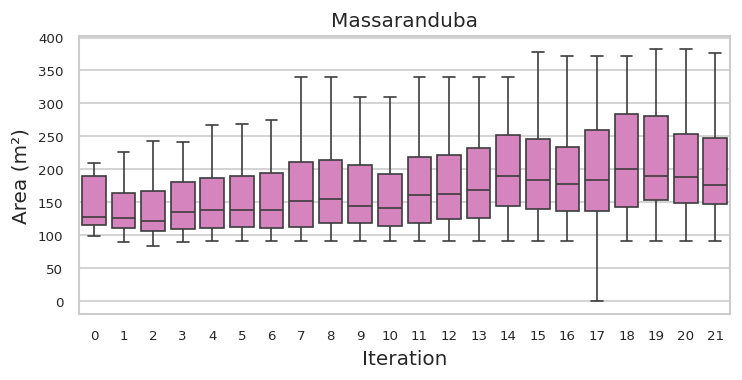

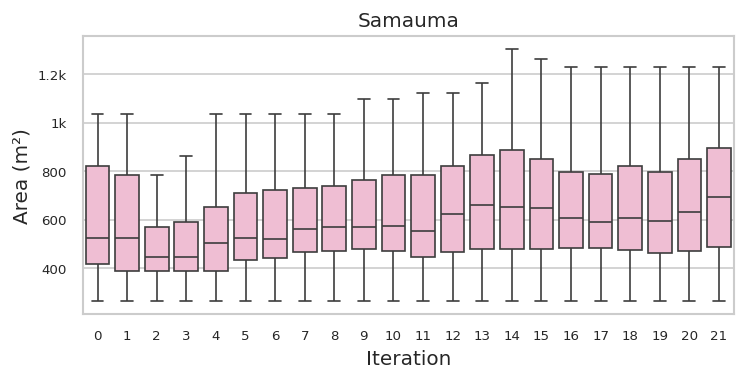

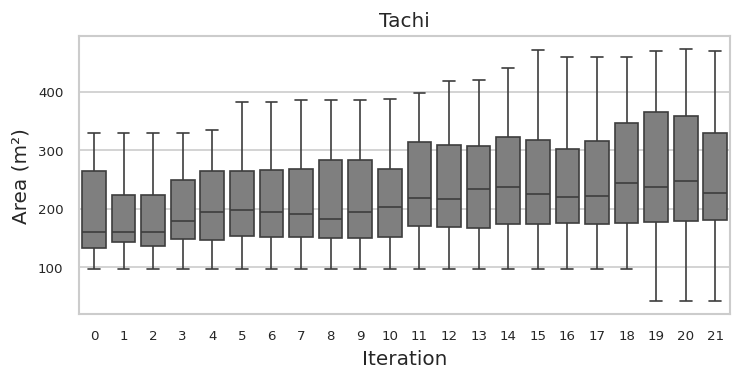

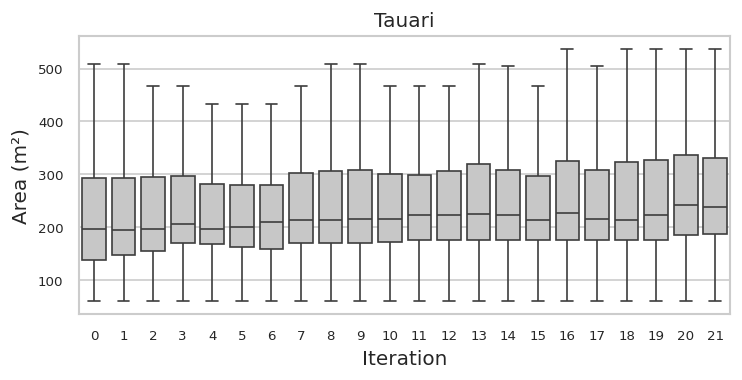

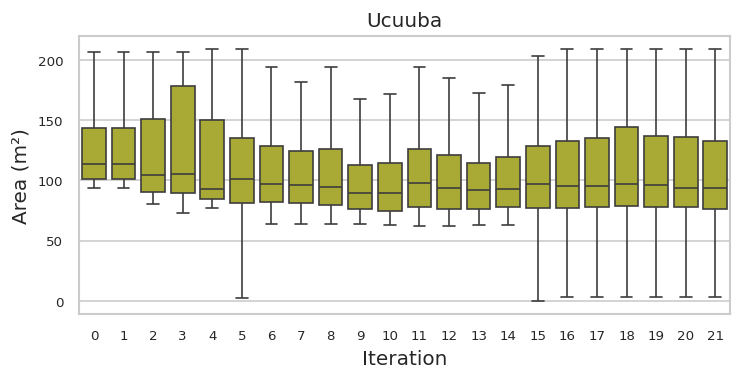

In [32]:
# Group the data by tree type
grouped_data = all_labels_stats.groupby('tree_name')

# Create a boxplot for each tree type
for num, (name, group) in enumerate(grouped_data):
    
    fig, axes = plt.subplots(figsize=(7, 3), sharey=True, sharex=True)

    sns.boxplot(
        group,
        x="iter_num",
        y="area_m2",
        hue = "tree_name",
        palette=dict_colors["tree_name"],
        ax = axes,
        showfliers = False
    )
    
    # Set the labels and title
    axes.set_xlabel('Iteration')
    axes.set_ylabel('Area (m²)')
    axes.set_title(f'{name}')
    format_millify_axis(axes, "y", precision=1)
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(format_y_ticks))
    # dont show legend
    axes.get_legend().remove()

    # Show the plot
    plt.show()



### Quanto a distribuição divergiu da média de sua espécie

In [33]:
distance_from_mean = all_labels_stats[["label","tree_type","iter_num","area_m2"]]

area_training_set = distance_from_mean[distance_from_mean["iter_num"] == 0].groupby("tree_type")["area_m2"].median()

distance_from_mean = distance_from_mean.merge(area_training_set, on="tree_type", suffixes=("", "_tree_type_mean"))

mean_dist_by_iter = distance_from_mean.groupby(["iter_num"], as_index=False)["area_m2"].mean()


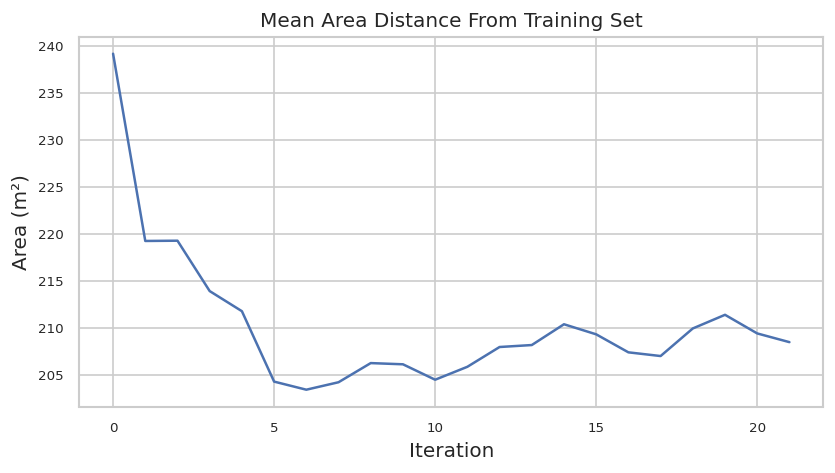

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=mean_dist_by_iter, x="iter_num", y="area_m2", ax=ax)

ax.set_title("Mean Area Distance from Training Set".title())
ax.set_ylabel("Area (m²)")
ax.set_xlabel("Iteration")

plt.show()

## Evolução das Métricas Durante as Iterações

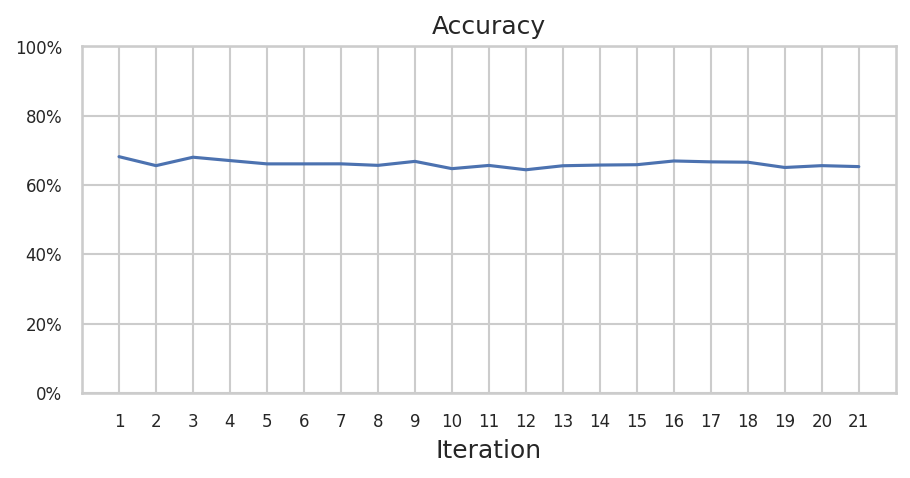

In [35]:
fig, ax = plt.subplots(figsize=(7,3), dpi=150)

ax = sns.lineplot(x=metrics_evo["iter_num"], y=metrics_evo["Accuracy"])
ax.set_title("Accuracy")

ax.set_ylim(0, 100)

ax.set_xlabel("Iteration")
ax.set_ylabel("")

format_axis(ax, "y", "{:.0f}%")
ax.set_xticks(metrics_evo["iter_num"].unique())

plt.show()

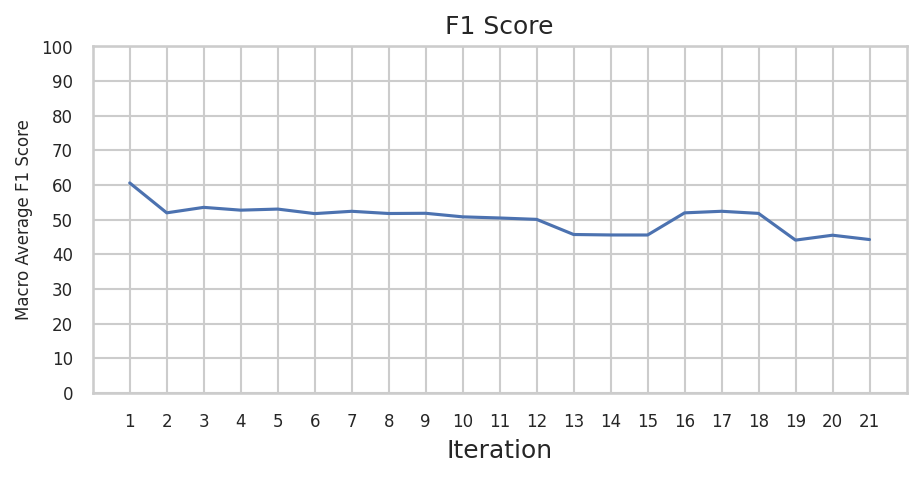

In [36]:
fig, ax = plt.subplots(figsize=(7,3), dpi=150)

ax = sns.lineplot(
    x=metrics_evo['iter_num'],
    y=metrics_evo["avgF1"]
)
ax.set_title("F1 Score")

ax.set_xticks(metrics_evo["iter_num"].unique())
ax.set_yticks(range(0, 101, 10))

ax.set_ylim(0, 100)

ax.set_xlabel("Iteration")
ax.set_ylabel("Macro Average F1 Score", fontsize=8)

plt.show()

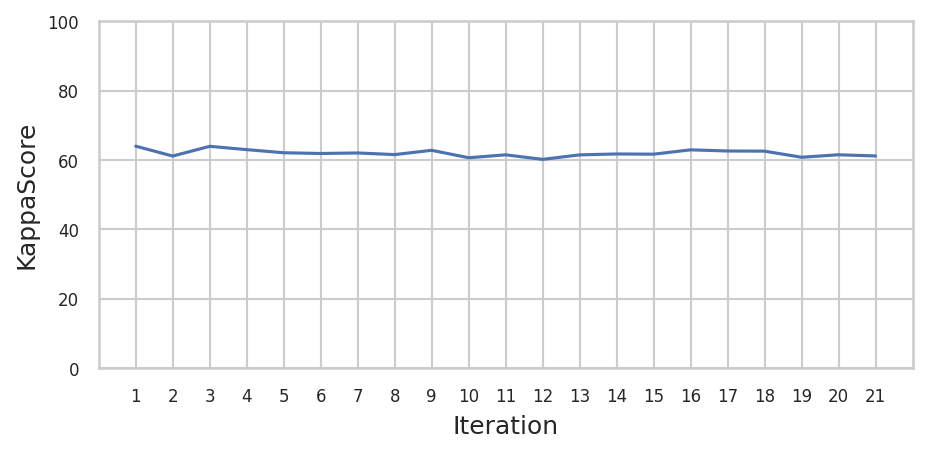

In [37]:
fig, ax = plt.subplots(figsize=(7,3), dpi=150)

ax = sns.lineplot(
    x=metrics_evo["iter_num"], 
    y=metrics_evo["KappaScore"]
)

# ax.set_title("KappaScore")

ax.set_xticks(metrics_evo["iter_num"].unique())
ax.set_ylim(0, 100)

ax.set_xlabel("Iteration")

plt.show()

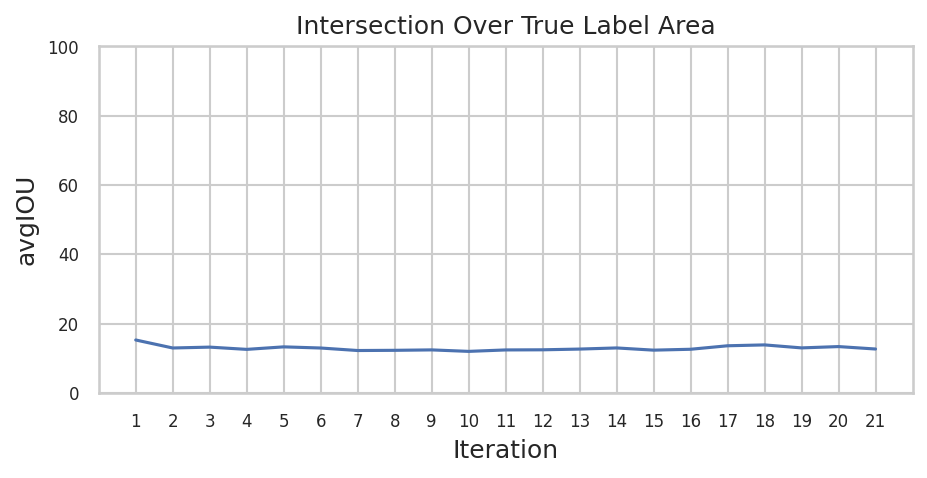

In [38]:
fig, ax = plt.subplots(figsize=(7,3), dpi=150)

ax = sns.lineplot(x=metrics_evo["iter_num"], y=metrics_evo["avgIOU"])

ax.set_title("Intersection Over True Label Area")

ax.set_xticks(metrics_evo['iter_num'].unique())
ax.set_ylim(0, 100)

ax.set_xlabel("Iteration")

plt.show()

## Evolução do F1-Score para Cada Espécie

In [39]:
metrics_evo_tree = metrics_evo["F1"].apply(pd.Series)

metrics_evo_tree_stack = metrics_evo_tree.stack().reset_index()

metrics_evo_tree_stack.rename(columns={0:"f1_score", "level_1":"tree_type",'level_0':"iter" }, inplace=True)

metrics_evo_tree_stack["iter"] += 1
metrics_evo_tree_stack["tree_type"] += 1

metrics_evo_tree_stack["tree_name"] = metrics_evo_tree_stack["tree_type"].map(id_tree)

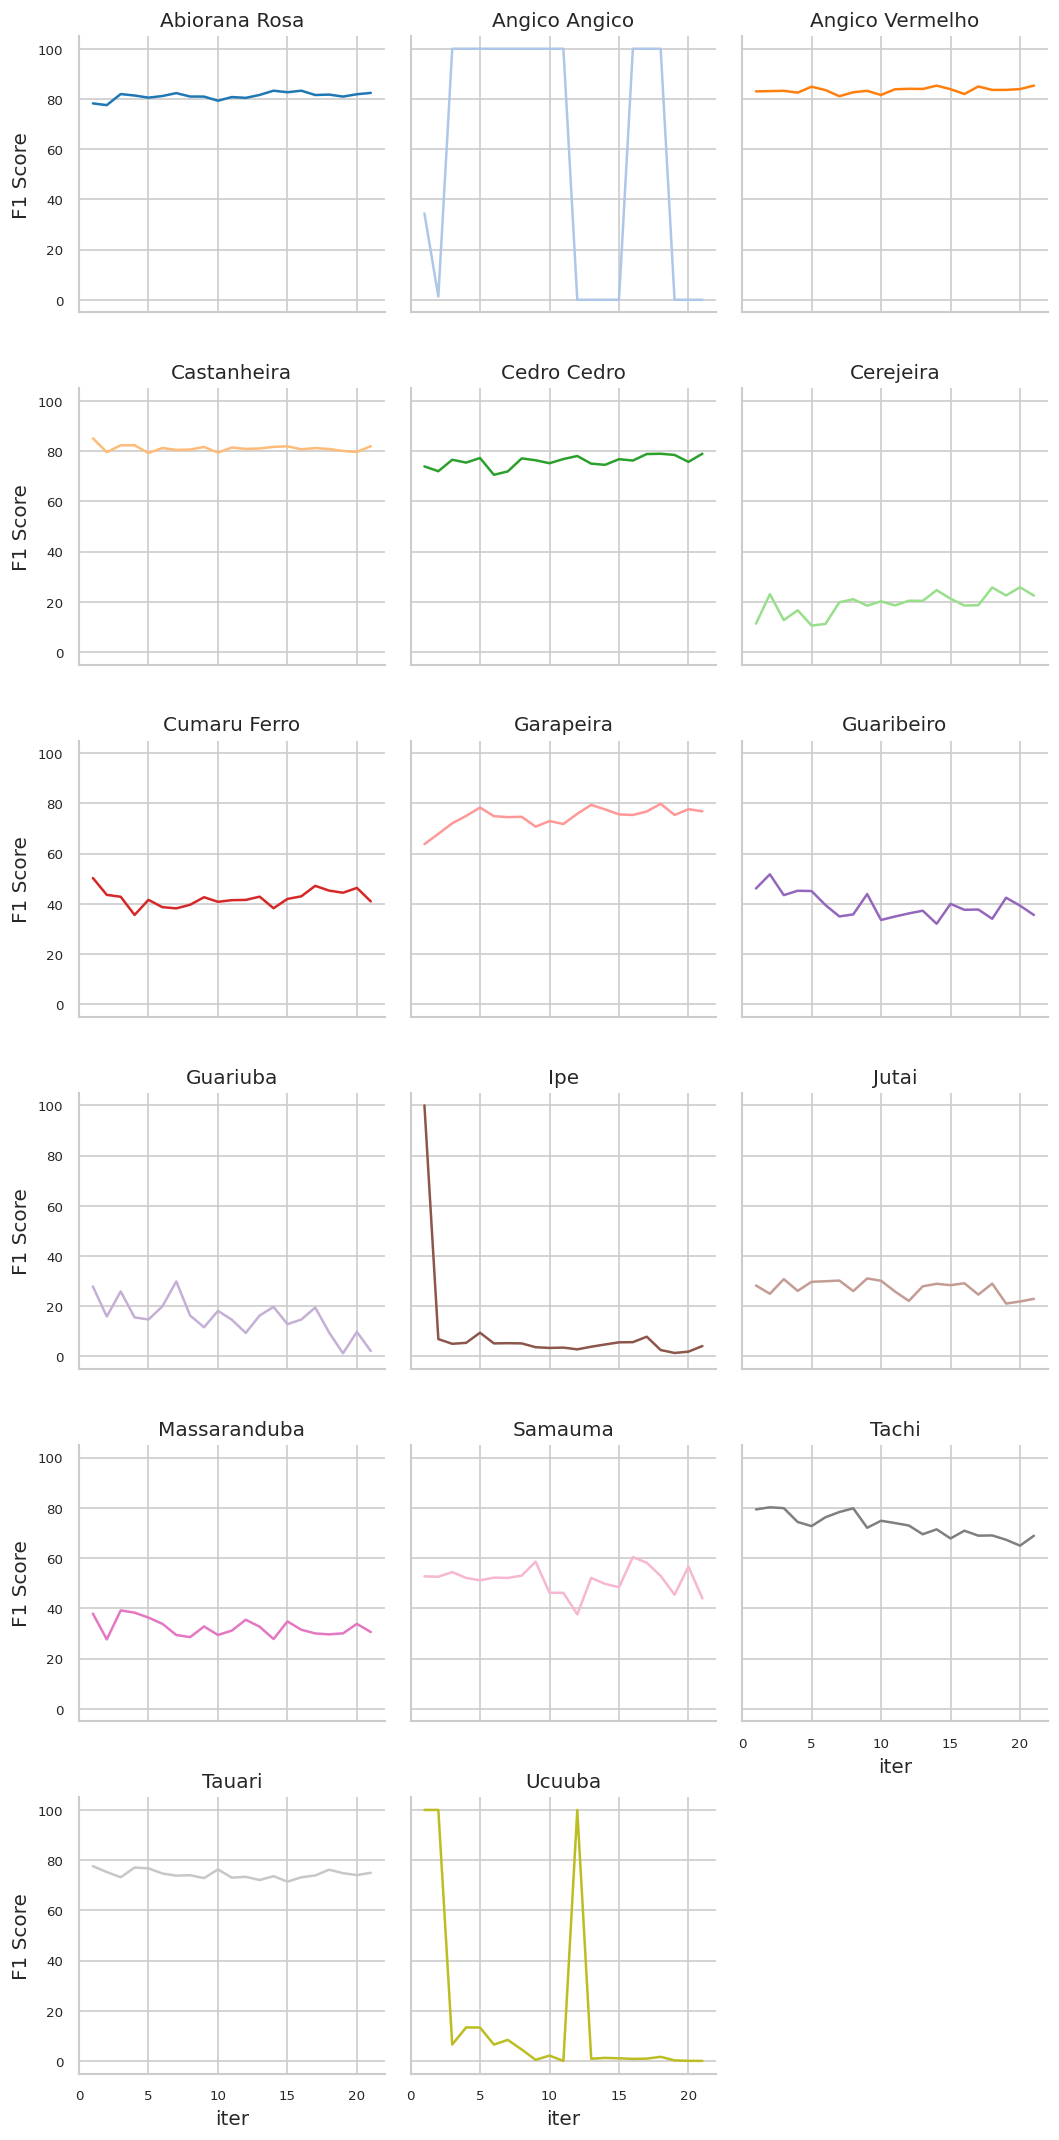

In [40]:
g = sns.FacetGrid(
    metrics_evo_tree_stack,
    col="tree_name",
    col_wrap=3, 
    hue = "tree_name",
    palette = dict_colors["tree_name"]
)

g.map(sns.lineplot, "iter", "f1_score")

g.set_titles("{col_name}")
g.set_ylabels("F1 Score")

plt.show()

In [41]:
VIEW_CONTOUR_PATH = join(DATA_PATH, "visualization", "synthetic_all_labels")

views_path = os.listdir(VIEW_CONTOUR_PATH)
views_path.sort()

LAST_VIEW = join(VIEW_CONTOUR_PATH, views_path[-1])

VIEW_SEG_CONTOUR = plt.imread(LAST_VIEW)

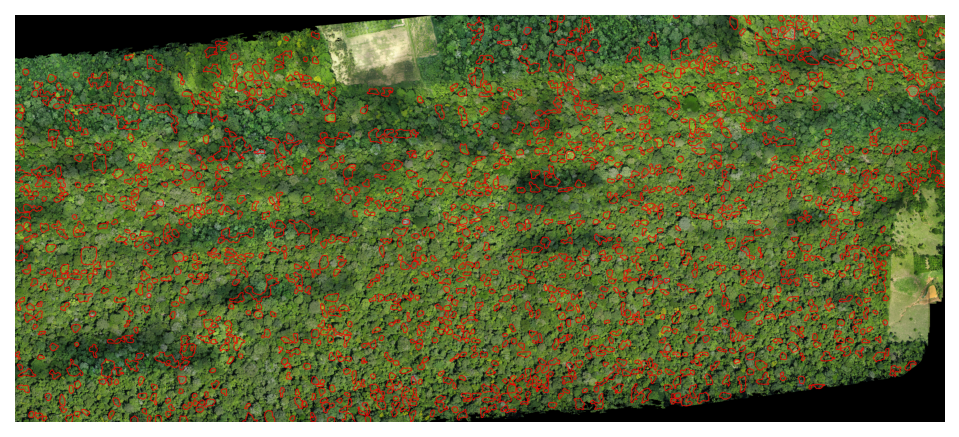

In [42]:
plt.figure(dpi = 150)
plt.imshow(VIEW_SEG_CONTOUR)
plt.axis("off")
plt.show()

## Animação da Evolução de Amostras

In [43]:
VIEW_SEG_PATH = join(DATA_PATH, "visualization", "all_labels")

# Load your images
image_paths = os.listdir(VIEW_SEG_PATH)  # Update with your image paths
image_paths = [join(VIEW_SEG_PATH, image_path) for image_path in image_paths]
image_paths.sort()

In [44]:
def load_image(path, rate_size=3):
    rate_size = int(np.sqrt(rate_size))
    image = Image.open(path)
    size = image.size
    image = image.resize((size[0]//rate_size, size[1]//rate_size), resample=Image.NEAREST)
    return image

In [45]:
segmentations = [load_image(path) for path in image_paths]

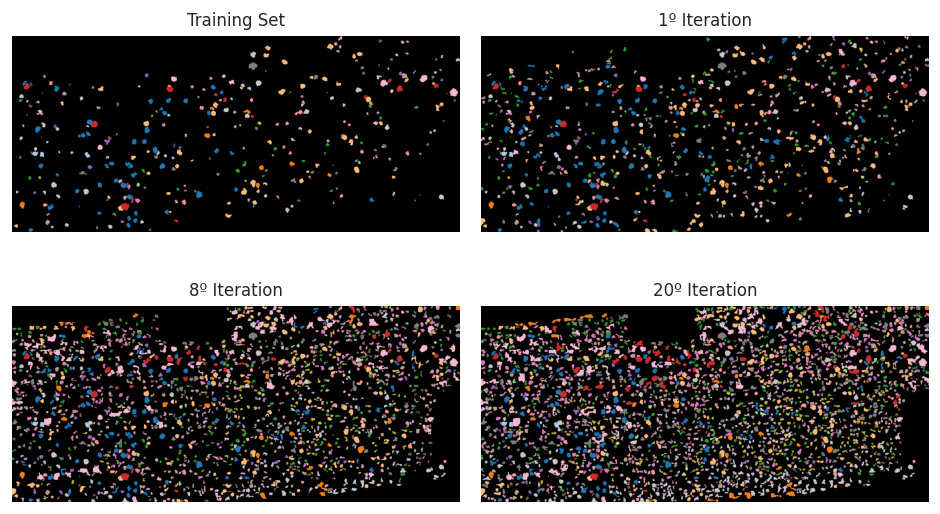

In [46]:
fig, ax = plt.subplots(2,2)

ax.flat[0].set_title("Training Set")
ax.flat[0].imshow(segmentations[0])

ax.flat[1].set_title("1º Iteration")
ax.flat[1].imshow(segmentations[1])

ax.flat[2].set_title("8º Iteration")
ax.flat[2].imshow(segmentations[8])

ax.flat[3].set_title("20º Iteration")
ax.flat[3].imshow(segmentations[20])


for axis in ax.flat:
    # set axis off
    axis.axis("off")
    # change title fontsize
    axis.title.set_fontsize(10)
    
fig.tight_layout()

In [47]:

# # Create a figure and axis
# fig, ax = plt.subplots()

# def init():
#     ax.imshow(segmentations[0])
#     ax.axis('off')  # Turn off axis

# # Function to update the plot for each frame of the animation
# def update(frame):
#     ax.imshow(segmentations[frame])
#     ax.axis('off')  # Turn off axis
#     ax.set_title(f"Iter: {frame}")

#     # return ax

# # Create the animation
# num_frames = len(segmentations)
# ani = FuncAnimation(fig, update, frames=num_frames, blit=False, interval = 1000)

# # Display the animation in the notebook
# # ani
# display(HTML(ani.to_jshtml()))

# plt.close()

In [48]:
# for num, image in enumerate(segmentations):
#     fig, ax = plt.subplots(dpi=100)

#     ax.set_title(f"Iter {num+1}")
    
#     ax.imshow(image)

#     ax.axis("off")
    
#     fig.show()
    

## Amostras de Segmentação de Algumas Espécies

In [49]:
def square_comp_coords(comp_id, comp_map, dim =256):
    coords = np.argwhere(comp_map == comp_id)

    down, top = coords[:, 0].max(),  coords[:, 0].min()

    right, left = coords[:, 1].max(),  coords[:, 1].min()

    down += dim//2
    top -= dim//2

    right += dim//2
    left -= dim//2

    #### create a square ###
    if np.abs(top-down) > np.abs(right - left):
        right = left + np.abs(top-down)

    if np.abs(top-down) < np.abs(right - left):
        down = top + np.abs(right - left)
    
    return np.maximum(0,left), right, np.maximum(0,top), down

In [50]:
SYNTHETIC_PRED = np.where(TRAIN_GT > 0, 0, PRED)
SYNTHETIC_COMP_PRED = label(SYNTHETIC_PRED)

In [51]:
synthetic_pred_stats = get_components_stats(SYNTHETIC_COMP_PRED, SYNTHETIC_PRED).reset_index()
synthetic_pred_stats["tree_name"] = synthetic_pred_stats["tree_type"].map(id_tree)

In [52]:
biggest_comp = synthetic_pred_stats.sort_values("area", ascending=False).groupby("tree_name").head(1).copy()

biggest_comp.sort_values("area", inplace = True, ascending=False)

biggest_comp_id = biggest_comp.head(9)["label"].values

# Exemplos das Predições com Maiores Áreas

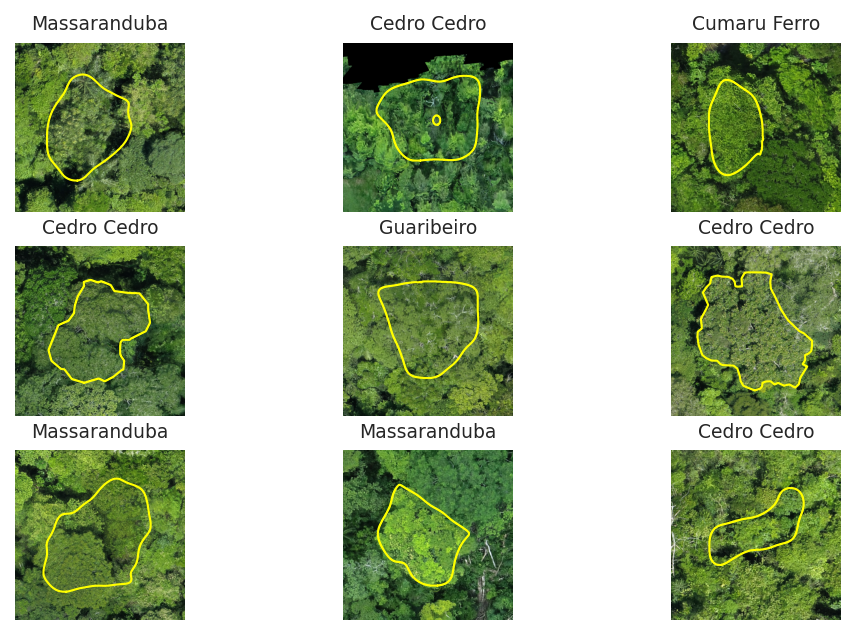

In [53]:
# Define plot dimensions
col_wrap = 3
nrows = int(np.ceil(len(biggest_comp_id)/col_wrap))

fig, ax = plt.subplots(ncols=col_wrap, nrows=nrows)
fig.set_dpi(150)

for num, comp_id in enumerate(biggest_comp_id):

    left, right, top, down = square_comp_coords(comp_id, COMP_PRED, 300)
    
    raw_image = ORTHOIMAGE[top:down, left:right].copy()
    
    pred_seg = PRED[top:down, left:right].copy()
    pred_seg = np.where(COMP_PRED[top:down, left:right] == comp_id, pred_seg, 0)
    
    tree_type = mode(pred_seg[pred_seg>0])

    tree_name = synthetic_pred_stats[synthetic_pred_stats["label"] == tree_type ]["tree_name"].item()
    

    ax.flat[num].set_title(tree_name, fontsize = 9)
    
    for contour in find_contours(pred_seg):
        ax.flat[num].plot(contour[:, 1], contour[:, 0], linewidth=1, color = "yellow")

    ax.flat[num].imshow(raw_image)
    
    ax.flat[num].axis("off")
    ax.flat[num].grid(False)


plt.axis("off")
plt.grid(False)

plt.show()

In [54]:
# load prob
PROB_PRED = read_tiff(
    glob(join(DATA_PATH,iter_folders[-1], "raster_prediction", "*prob*"))[0]
)
# convert to uint8 format
PROB_PRED = (PROB_PRED/PROB_PRED.max()*255).astype(np.uint8)

# load prob
DEPTH_PRED = read_tiff(
    glob(join(DATA_PATH,iter_folders[-1], "raster_prediction", "*depth*"))[0]
)
# convert to uint8 format
DEPTH_PRED = (DEPTH_PRED/DEPTH_PRED.max()*255).astype(np.uint8)

### Mapa de Distância desses Exemplos

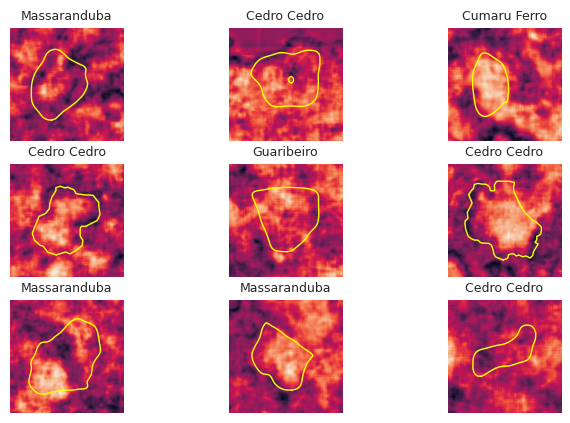

In [55]:
# Define plot dimensions
col_wrap = 3
nrows = int(np.ceil(len(biggest_comp_id)/col_wrap))

fig, ax = plt.subplots(ncols=col_wrap, nrows=nrows)
fig.set_dpi(100)

for num, comp_id in enumerate(biggest_comp_id):

    left, right, top, down = square_comp_coords(comp_id, COMP_PRED, 300)
    
    raw_image = DEPTH_PRED[top:down, left:right].view()
    raw_image[raw_image < (255)*0.1] = 0
    
    pred_seg = PRED[top:down, left:right].view()
    pred_seg = np.where(COMP_PRED[top:down, left:right] == comp_id, pred_seg, 0)
    
    tree_type = mode(pred_seg[pred_seg>0])

    tree_name = synthetic_pred_stats[synthetic_pred_stats["label"] == tree_type ]["tree_name"].item()
    
    ax.flat[num].set_title(tree_name, fontsize = 9)
    
    for contour in find_contours(pred_seg):
        ax.flat[num].plot(contour[:, 1], contour[:, 0], linewidth=1, color = "yellow")

    ax.flat[num].imshow(raw_image)
    
    ax.flat[num].axis("off")
    ax.flat[num].grid(False)


plt.axis("off")
plt.grid(False)

plt.show()

### Mapa de Probabilidade desses Exemplos

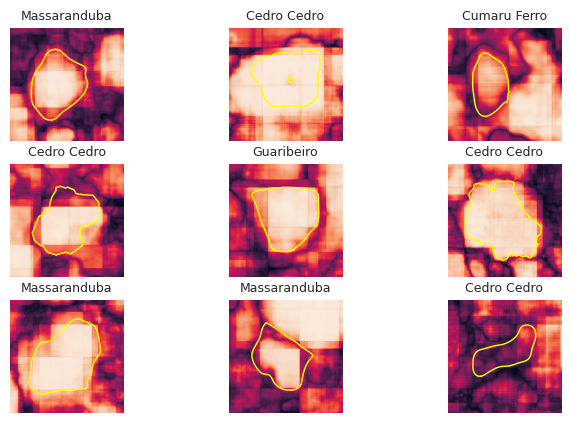

In [56]:
# Define plot dimensions
col_wrap = 3
nrows = int(np.ceil(len(biggest_comp_id)/col_wrap))

fig, ax = plt.subplots(ncols=col_wrap, nrows=nrows)
fig.set_dpi(100)

for num, comp_id in enumerate(biggest_comp_id):

    left, right, top, down = square_comp_coords(comp_id, COMP_PRED, 300)
    
    raw_image = PROB_PRED[top:down, left:right].copy()
    
    pred_seg = PRED[top:down, left:right].copy()
    pred_seg = np.where(COMP_PRED[top:down, left:right] == comp_id, pred_seg, 0)
    
    tree_type = mode(pred_seg[pred_seg>0])

    tree_name = synthetic_pred_stats[synthetic_pred_stats["label"] == tree_type ]["tree_name"].item()
    
    ax.flat[num].set_title(tree_name, fontsize = 9)
    
    for contour in find_contours(pred_seg):
        ax.flat[num].plot(contour[:, 1], contour[:, 0], linewidth=1, color = "yellow")

    ax.flat[num].imshow(raw_image)
    
    ax.flat[num].axis("off")
    ax.flat[num].grid(False)


plt.axis("off")
plt.grid(False)

plt.show()

### Mapa de Probabilidades com Threshold 0.7

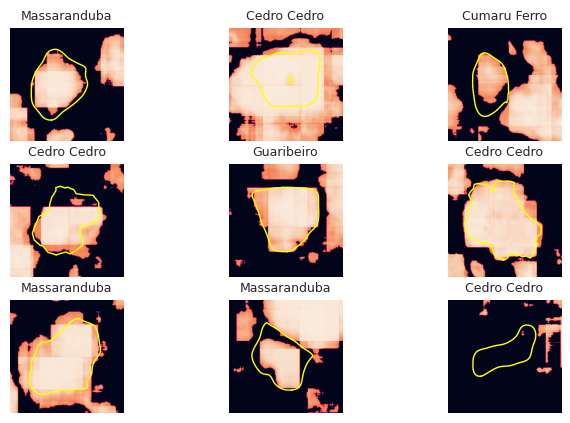

In [57]:
# Define plot dimensions
col_wrap = 3
nrows = int(np.ceil(len(biggest_comp_id)/col_wrap))

fig, ax = plt.subplots(ncols=col_wrap, nrows=nrows)
fig.set_dpi(100)

for num, comp_id in enumerate(biggest_comp_id):

    left, right, top, down = square_comp_coords(comp_id, COMP_PRED, 300)
    
    raw_image = PROB_PRED[top:down, left:right].copy()
    raw_image[raw_image < 255*(0.7)] = 0
    
    pred_seg = PRED[top:down, left:right].copy()
    pred_seg = np.where(COMP_PRED[top:down, left:right] == comp_id, pred_seg, 0)
    
    tree_type = mode(pred_seg[pred_seg>0])

    tree_name = synthetic_pred_stats[synthetic_pred_stats["label"] == tree_type ]["tree_name"].item()
    
    ax.flat[num].set_title(tree_name, fontsize = 9)
    
    for contour in find_contours(pred_seg):
        ax.flat[num].plot(contour[:, 1], contour[:, 0], linewidth=1, color = "yellow")

    ax.flat[num].imshow(raw_image)
    
    ax.flat[num].axis("off")
    ax.flat[num].grid(False)


plt.axis("off")
plt.grid(False)

plt.show()

In [58]:
pred_id_in_test = np.unique(COMP_PRED[TEST_GT > 0])
pred_id_in_test = pred_id_in_test[np.nonzero(pred_id_in_test)]

PRED_IN_TEST = np.where(np.isin(COMP_PRED, pred_id_in_test), PRED, 0)
COMP_PRED_IN_TEST = np.where(np.isin(COMP_PRED, pred_id_in_test), COMP_PRED, 0)


In [59]:
last_iter_stats = all_labels_stats[all_labels_stats["iter_num"] == all_labels_stats["iter_num"].max()]

### Predições com Intersecção com o conjunto de teste

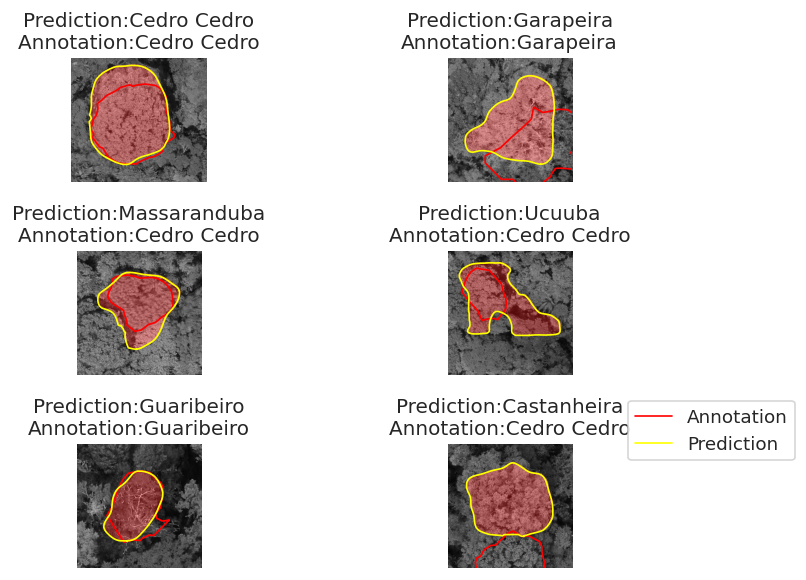

In [60]:
# Define plot dimensions
col_wrap = 2
num_samples = 5
nrows = int(np.ceil(num_samples/col_wrap))

fig, ax = plt.subplots(ncols=col_wrap, nrows=nrows)

tree_types_already_plotted = []
num = 0
for comp_id in pred_id_in_test:

    left, right, top, down = square_comp_coords(comp_id, COMP_PRED)
    
    raw_image = ORTHOIMAGE[top:down, left:right].copy()
    gt_seg = TEST_GT[top:down, left:right].copy()
    pred_seg = PRED_IN_TEST[top:down, left:right].copy()

    
    pred_label_num = mode(pred_seg[pred_seg>0])
    pred_seg = np.where(pred_seg == pred_label_num, pred_seg, 0)
    pred_tree_type = last_iter_stats[last_iter_stats["label"] == pred_label_num ]["tree_name"].item()


    gt_label_num = mode(gt_seg[gt_seg>0])
    gt_tree_type = last_iter_stats[last_iter_stats["label"] == gt_label_num ]["tree_name"].item()
    

    if pred_tree_type in tree_types_already_plotted:
        continue
    
    else:
        tree_types_already_plotted.append(pred_tree_type)
    

    ax.flat[num].set_title(
        f"Prediction:{pred_tree_type}\nAnnotation:{gt_tree_type}"
    )
    
    ax.flat[num].imshow(label2rgb(pred_seg, raw_image))

    for contour in find_contours(gt_seg):
        ax.flat[num].plot(contour[:, 1], contour[:, 0], linewidth=1, color = "red", label = "Annotation")
    
    for contour in find_contours(pred_seg):
        ax.flat[num].plot(contour[:, 1], contour[:, 0], linewidth=1, color = "yellow", label = "Prediction")
    


    ax.flat[num].axis("off")
    ax.flat[num].grid(False)
    
    
    if num == num_samples:
        break
    num += 1


# set
handles, labels = ax.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right', bbox_to_anchor=(1, 0.2), title='') 

plt.tight_layout()
plt.grid(False)
plt.axis("off")
plt.show()

# Exportando Relatório

In [61]:
# Example of running 'ls -l' and capturing output
VERSION_NAME = os.path.split(DATA_PATH)[-1]
result = subprocess.run([
    "python3", 
    "-m",
    "nbconvert", 
    "--to", 
    "html",
    "--no-input",
    f"--output-dir={DATA_PATH}",
    "--output",
    f"{VERSION_NAME}_metrics",
    f"report_metrics.ipynb"], 
    capture_output=True, 
    text=True
)

print(result.stderr)

[NbConvertApp] Converting notebook report_metrics.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 38 image(s).
[NbConvertApp] Writing 5714059 bytes to /home/luiz.luz/multi-task-fcn/13_amazon_data/13_amazon_data_metrics.html



In [62]:
# Example of running 'ls -l' and capturing output
VERSION_NAME = os.path.split(DATA_PATH)[-1]
result = subprocess.run([
    "python3", 
    "-m",
    "nbconvert", 
    "--to", 
    "pdf",
    "--no-input",
    f"--output-dir={DATA_PATH}",
    "--output",
    f"{VERSION_NAME}_metrics.pdf",
    f"report_metrics.ipynb"], 
    capture_output=True, 
    text=True
)

print(result.stderr)

[NbConvertApp] Converting notebook report_metrics.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'report_metrics.ipynb'
Traceback (most recent call last):
  File "/home/luiz.luz/multi-task-fcn/.env/lib/python3.10/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
  File "/home/luiz.luz/multi-task-fcn/.env/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
  File "/home/luiz.luz/multi-task-fcn/.env/lib/python3.10/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
  File "/home/luiz.luz/multi-task-fcn/.env/lib/python3.10/site-packages/nbconvert/exporters/templateexporter.py", line 392, in from_file
    return super().from_file(file_stream, resources, **kw)  # type:ignore[return-value]
